In [3]:
from langchain_community.tools.tavily_search import TavilySearchResults
from dotenv import load_dotenv
import os

load_dotenv()

os.environ["TAVILY_API_KEY"]=os.getenv("TAVILY_API_KEY")

tool=TavilySearchResults(max_results=2)
tools=[tool]
result=tool.invoke("What is a neural network?")

In [10]:
print(result[0]["content"])

A neural network, or artificial neural network, is a type of computing architecture that is based on a model of how a human brain functions — hence the name "neural." Neural networks are made up of a collection of processing units called "nodes." These nodes pass data to each other, just like how in a brain, neurons pass electrical impulses to each other. [...] What is a neural network? | Types of neural networks | Cloudflare

skip to contentSales: +1 (650) 319 8930
Support
Log in
SolutionsProductsPricingResourcesPartnersWhy Cloudflare
Support
Sign up
Sign upContact salesLog in

Log in
SolutionsProductsPricingResourcesPartnersWhy Cloudflare
Support
Sign up
What is a neural network?
Neural networks are a crucial component of artificial intelligence (AI) models. They work based on an architecture that imitates the human brain's neurons.
Learning Center [...] Neural networks are used in machine learning, which refers to a category of computer programs that learn without definite instructi

In [144]:
load_dotenv()

gemini_api_key=os.getenv("GEMINI_API_KEY")
groq_api_key=os.getenv("GROQ_API_KEY")
os.environ["OPENAI_API_KEY"]=os.getenv("OPENAI_API_KEY")

In [45]:
from typing import Annotated
from typing_extensions import TypedDict
from langchain_google_genai import ChatGoogleGenerativeAI

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

class State(TypedDict):
    message: Annotated[list,add_messages]

llm=ChatGoogleGenerativeAI(
    model="gemini-2.0-flash",
    api_key=gemini_api_key
)

graph_builder=StateGraph(State)

llm_with_tools=llm.bind_tools(tools=tools)

def chatbot(state:State):
    return {"messages":[llm_with_tools.invoke(state["messages"])]}
    
graph_builder.add_node("chatbot",chatbot)
# graph_builder.set_entry_point("chatbot")
# graph_builder.set_finish_point("chatbot")

# graph=graph_builder.compile()

# response = graph.invoke({"message": [{"role": "user", "content": "Hey, what's a neural network?"}]})
# print(response)

In [46]:
import json
from langchain_core.messages import ToolMessage
from langgraph.prebuilt import ToolNode, tools_condition

class BasicToolNode:
    """A node that runs the tools requested in the last AIMessage."""

    def __init__(self, tools: list) -> None:
        self.tools_by_name={tool.name:tool for tool in tools}

    def __call__(self, inputs: dict):
        # messages=inputs.get("messages",[])
        if messages:=inputs.get("messages",[]):
            message=messages[-1]

        else:
            raise ValueError("No message found in input")
        
        outputs=[]

        for tool_call in message.tool_calls:

            tool_result=self.tools_by_name[tool_call["name"]].invoke(tool_call["args"])

            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"]
                )
            )

        return {"messages":outputs}
    
tool_node=ToolNode(tools=[tool])
graph_builder.add_node("tools",tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)

graph_builder.add_edge("tools","chatbot")
graph_builder.set_entry_point("chatbot")
graph=graph_builder.compile()

In [36]:
def route_tools(
    state: State,
):
    """
    Use in the conditional_edge to route to the ToolNode if the last message
    has tool calls. Otherwise, route to the end.
    """
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return END


# The `tools_condition` function returns "tools" if the chatbot asks to use a tool, and "END" if
# it is fine directly responding. This conditional routing defines the main agent loop.
graph_builder.add_conditional_edges(
    "chatbot",
    route_tools,
    # The following dictionary lets you tell the graph to interpret the condition's outputs as a specific node
    # It defaults to the identity function, but if you
    # want to use a node named something else apart from "tools",
    # You can update the value of the dictionary to something else
    # e.g., "tools": "my_tools"
    {"tools": "tools", END: END},
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph = graph_builder.compile()

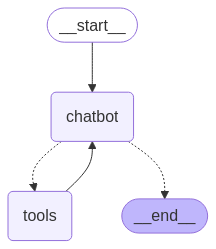

In [47]:
from IPython.display import display, Image
display(Image(graph.get_graph().draw_mermaid_png()))

In [48]:
def stream_graph_updates(user_input: str):

    for event in graph.stream(
        {
            "messages":[{"role":"user","content":user_input}]
        }
    ):
        for value in event.values():
            print(value)

stream_graph_updates("What do you know about neural networks?")

KeyError: 'messages'

In [51]:
from typing import Annotated

from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


tool = TavilySearchResults(max_results=2)
tools = [tool]
llm = ChatGoogleGenerativeAI(
    model="gemini-2.0-flash",
    api_key=gemini_api_key
)
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.set_entry_point("chatbot")
graph = graph_builder.compile()

In [97]:
def stream_graph_updates(user_input: str):
    results=[]
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            # print(value)
            results.append(value)

    return results[-1]["messages"][0].content

response=stream_graph_updates("what is a neural network?")

In [98]:
print(response)

A neural network is a machine learning model that mimics the way the human brain makes decisions. It uses processes similar to how biological neurons work together to identify phenomena, weigh options, and arrive at conclusions. Neural networks are also called artificial neural networks (ANNs) or simulated neural networks (SNNs). They are a subset of machine learning and are at the heart of deep learning models.


In [102]:
from langgraph.checkpoint.memory import MemorySaver
memory=MemorySaver()

In [103]:
from typing import Annotated

from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


tool = TavilySearchResults(max_results=2)
tools = [tool]
llm = ChatGoogleGenerativeAI(
    model="gemini-2.0-flash",
    api_key=gemini_api_key
)
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.set_entry_point("chatbot")
graph = graph_builder.compile(checkpointer=memory)

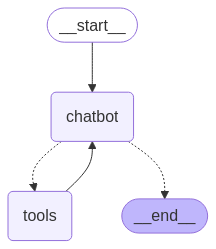

In [104]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [105]:
config={"configurable":{"thread_id":"1"}}

user_input="Hi! My name is Soham"
events=graph.stream(
    {
        "messages":[{"role":"user","content":user_input}]
    },
    config=config,
    stream_mode="values"
)

for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Hi! My name is Soham
================================== Ai Message ==================================

Hello Soham, nice to meet you!


In [108]:
user_input="Remember my name?"
events=graph.stream(
    {
        "messages":[{"role":"user","content":user_input}]
    },
    config=config,
    stream_mode="values"
)

for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Remember my name?
================================== Ai Message ==================================

Yes, your name is still Soham.


In [107]:
# The only difference is we change the `thread_id` here to "2" instead of "1"
events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    {"configurable": {"thread_id": "2"}},
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Remember my name?
================================== Ai Message ==================================

I do not have the capability to remember information from previous conversations.


In [110]:
state=graph.get_state(config=config)
state

StateSnapshot(values={'messages': [HumanMessage(content='Hi! My name is Soham', additional_kwargs={}, response_metadata={}, id='0e578805-b4c1-49ab-92e6-1c1199b08015'), AIMessage(content='Hello Soham, nice to meet you!', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-7530beef-a1da-4136-8ca5-21ace4dca72b-0', usage_metadata={'input_tokens': 54, 'output_tokens': 10, 'total_tokens': 64, 'input_token_details': {'cache_read': 0}}), HumanMessage(content='Remember my name?', additional_kwargs={}, response_metadata={}, id='242bf937-bde1-42bc-84d8-14e257b2e443'), AIMessage(content='Yes, your name is Soham.', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-8d770e68-9d98-447b-a11f-005042c81787-0', usage_metadata={'input_tokens': 67, 'output_tokens': 9, 'total_tokens': 76, 'input_

In [114]:
state.values

{'messages': [HumanMessage(content='Hi! My name is Soham', additional_kwargs={}, response_metadata={}, id='0e578805-b4c1-49ab-92e6-1c1199b08015'),
  AIMessage(content='Hello Soham, nice to meet you!', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-7530beef-a1da-4136-8ca5-21ace4dca72b-0', usage_metadata={'input_tokens': 54, 'output_tokens': 10, 'total_tokens': 64, 'input_token_details': {'cache_read': 0}}),
  HumanMessage(content='Remember my name?', additional_kwargs={}, response_metadata={}, id='242bf937-bde1-42bc-84d8-14e257b2e443'),
  AIMessage(content='Yes, your name is Soham.', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-8d770e68-9d98-447b-a11f-005042c81787-0', usage_metadata={'input_tokens': 67, 'output_tokens': 9, 'total_tokens': 76, 'input_token_details':

In [135]:
from typing import Annotated

from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage
from langchain_core.tools import tool
from typing_extensions import TypedDict

from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.types import Command, interrupt
from langgraph.checkpoint.memory import MemorySaver

class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)



@tool
def human_assistance(query:str)->str:
    """Request assistance from a human."""
    human_response=interrupt({"query":query})
    return human_response["data"]

tool = TavilySearchResults(max_results=2)

tools = [tool,human_assistance]
llm = ChatGoogleGenerativeAI(
    model="gemini-2.0-flash",
    api_key=gemini_api_key
)
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):

    # message=llm_with_tools.invoke(state["messages"])
    # assert len(message.tool_calls)<=1
    # return {"messages":[message]}
    message = llm_with_tools.invoke(state["messages"])
    # Because we will be interrupting during tool execution,
    # we disable parallel tool calling to avoid repeating any
    # tool invocations when we resume.
    assert len(message.tool_calls) <= 1
    return {"messages": [message]}



graph_builder.add_node("chatbot", chatbot)


tool_node = ToolNode(tools=[tool,human_assistance])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)

memory=MemorySaver()

# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.set_entry_point("chatbot")
graph = graph_builder.compile(checkpointer=memory)

In [136]:
user_input = "I need some expert guidance for building an AI agent. Could you request assistance for me?"
config = {"configurable": {"thread_id": "1"}}

events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I need some expert guidance for building an AI agent. Could you request assistance for me?
================================== Ai Message ==================================
Tool Calls:
  human_assistance (d76645d6-c1d0-4f40-9dfb-efe9cc381783)
 Call ID: d76645d6-c1d0-4f40-9dfb-efe9cc381783
  Args:
    query: I need expert guidance on building an AI agent. Can you provide resources, best practices, and potential pitfalls to avoid?


In [129]:
snapshot=graph.get_state(config=config)
snapshot

StateSnapshot(values={'messages': [HumanMessage(content='I need some expert guidance for building an AI agent. Could you request assistance for me?', additional_kwargs={}, response_metadata={}, id='5883daa6-06f0-4002-9703-d9c70479a23b'), AIMessage(content='', additional_kwargs={'function_call': {'name': 'human_assistance', 'arguments': '{"query": "I need expert guidance on building an AI agent. Could you provide some assistance?"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-6c9327bf-86a7-4470-8cfe-b6885ab49d6b-0', tool_calls=[{'name': 'human_assistance', 'args': {'query': 'I need expert guidance on building an AI agent. Could you provide some assistance?'}, 'id': 'b6a56bb8-b312-4b5c-a27a-f2dcb3c60999', 'type': 'tool_call'}], usage_metadata={'input_tokens': 76, 'output_tokens': 20, 'total_tokens': 96, 'input_token_details': {'cache_read': 0}})]}, next=('tools',), config={'configurable': {'th

In [130]:
snapshot.next

('tools',)

In [131]:
snapshot.values

{'messages': [HumanMessage(content='I need some expert guidance for building an AI agent. Could you request assistance for me?', additional_kwargs={}, response_metadata={}, id='5883daa6-06f0-4002-9703-d9c70479a23b'),
  AIMessage(content='', additional_kwargs={'function_call': {'name': 'human_assistance', 'arguments': '{"query": "I need expert guidance on building an AI agent. Could you provide some assistance?"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-6c9327bf-86a7-4470-8cfe-b6885ab49d6b-0', tool_calls=[{'name': 'human_assistance', 'args': {'query': 'I need expert guidance on building an AI agent. Could you provide some assistance?'}, 'id': 'b6a56bb8-b312-4b5c-a27a-f2dcb3c60999', 'type': 'tool_call'}], usage_metadata={'input_tokens': 76, 'output_tokens': 20, 'total_tokens': 96, 'input_token_details': {'cache_read': 0}})]}

In [137]:
human_response=(
    "We, the experts are here to help! We'd recommend you check out LangGraph to build your agent."
    " It's much more reliable and extensible than simple autonomous agents."
)

human_command=Command(resume={"data":human_response})

events=graph.stream(human_command,config,stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  human_assistance (d76645d6-c1d0-4f40-9dfb-efe9cc381783)
 Call ID: d76645d6-c1d0-4f40-9dfb-efe9cc381783
  Args:
    query: I need expert guidance on building an AI agent. Can you provide resources, best practices, and potential pitfalls to avoid?
================================= Tool Message =================================
Name: human_assistance

We, the experts are here to help! We'd recommend you check out LangGraph to build your agent. It's much more reliable and extensible than simple autonomous agents.
================================== Ai Message ==================================

The experts recommend using LangGraph to build your AI agent, as it is more reliable and extensible than simple autonomous agents.


In [157]:
from typing import Annotated

from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage
from langchain_core.tools import tool
from langchain_groq import ChatGroq
from langchain_openai import ChatOpenAI
from typing_extensions import TypedDict

from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.types import Command, interrupt
from langgraph.checkpoint.memory import MemorySaver

class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

memory=MemorySaver()

# @tool
# def human_assistance(query:str)->str:
#     """Request assistance from a human."""
#     human_response=interrupt({"query":query})
#     return human_response["data"]

tool = TavilySearchResults(max_results=5)

tools = [tool]
# llm = ChatGoogleGenerativeAI(
#     model="gemini-2.0-flash",
#     api_key=gemini_api_key
# )

# llm=ChatGroq(
#     model="qwen-qwq-32b",
#     api_key=groq_api_key
# )

llm=ChatOpenAI(
    model="gpt-4o"
)

llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):

    # message=llm_with_tools.invoke(state["messages"])
    # assert len(message.tool_calls)<=1
    # return {"messages":[message]}
    message = llm_with_tools.invoke(state["messages"])
    # Because we will be interrupting during tool execution,
    # we disable parallel tool calling to avoid repeating any
    # tool invocations when we resume.
    assert len(message.tool_calls) <= 1
    return {"messages": [message]}



graph_builder.add_node("chatbot", chatbot)


tool_node = ToolNode(tools=[tool,human_assistance])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)

memory=MemorySaver()

# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.set_entry_point("chatbot")
graph = graph_builder.compile(checkpointer=memory)

In [158]:
config={"configurable":{"thread_id":"1"}}
events = graph.stream(
    {
        "messages": [
            {
                "role": "user",
                "content": (
                    "I'm learning LangGraph. "
                    "Could you do some research on it for me?"
                ),
            },
        ],
    },
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I'm learning LangGraph. Could you do some research on it for me?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_DZzp01HhR3OQlJxsd0xkitw9)
 Call ID: call_DZzp01HhR3OQlJxsd0xkitw9
  Args:
    query: LangGraph programming language
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "LangGraph: Build Stateful AI Agents in Python", "url": "https://realpython.com/langgraph-python/", "content": "Remove ads\nLangGraph is a versatile Python library designed for stateful, cyclic, and multi-actor Large Language Model (LLM) applications. LangGraph builds upon its parent library, LangChain, and allows you to build sophisticated workflows that are capable of handling the complexities of real-world LLM applications.\nBy the end of this tutorial, you’ll understand that

In [159]:
events = graph.stream(
    {
        "messages": [
            {
                "role": "user",
                "content": (
                    "Ya that's helpful. Maybe I'll "
                    "build an autonomous agent with it!"
                ),
            },
        ],
    },
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

Ya that's helpful. Maybe I'll build an autonomous agent with it!
================================== Ai Message ==================================

That sounds like a fantastic project! Building an autonomous agent with LangGraph could be a great way to leverage its capabilities in managing complex workflows and stateful interactions. If you have any questions or need further guidance while working on your project, feel free to ask. Good luck, and happy coding!


In [160]:
events = graph.stream(
    {
        "messages": [
            {
                "role": "user",
                "content": (
                    "Can you help me do it?"
                    "Can you give me a step by step walkthrough"
                ),
            },
        ],
    },
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

Can you help me do it?Can you give me a step by step walkthrough
================================== Ai Message ==================================

Creating an autonomous agent using LangGraph involves several steps to set up and implement the desired functionality. Here's a step-by-step walkthrough to help you get started:

### Step 1: Set Up Your Environment

1. **Install Python**: Ensure you have Python installed on your computer. You can download it from [Python's official website](https://www.python.org/).

2. **Set Up a Virtual Environment**: It's a good practice to use a virtual environment for your project to manage dependencies.
   ```bash
   python -m venv langgraph_env
   source langgraph_env/bin/activate  # On Windows use `.\langgraph_env\Scripts\activate`
   ```

3. **Install Required Libraries**: Install LangGraph along with LangChain and any other dependencies.
   ```bash
   pip install lang

In [156]:
for event in events:
    event["messages"][-1].pretty_print()

In [166]:
print(graph.get_state(config=config).values["messages"][-1].content)

Creating an autonomous agent using LangGraph involves several steps to set up and implement the desired functionality. Here's a step-by-step walkthrough to help you get started:

### Step 1: Set Up Your Environment

1. **Install Python**: Ensure you have Python installed on your computer. You can download it from [Python's official website](https://www.python.org/).

2. **Set Up a Virtual Environment**: It's a good practice to use a virtual environment for your project to manage dependencies.
   ```bash
   python -m venv langgraph_env
   source langgraph_env/bin/activate  # On Windows use `.\langgraph_env\Scripts\activate`
   ```

3. **Install Required Libraries**: Install LangGraph along with LangChain and any other dependencies.
   ```bash
   pip install langgraph langchain
   ```

### Step 2: Define Your Agent's Architecture

1. **Identify the Agent's Goals**: Determine what you want the autonomous agent to accomplish. This could range from data processing tasks to interactive appli